In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
from matplotlib import animation
%matplotlib qt

def W_init(shape,name=None,dtype='float32'):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None,dtype='float32'):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
 
#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
for layer in convnet.layers:
    weights = layer.get_weights()
    print(weights)
siamese_net.count_params()

Using TensorFlow backend.


[array([[[[-1.47762746e-02,  1.30205071e-02, -1.30744381e-02, ...,
           6.97487732e-03,  3.27108521e-03, -9.73393582e-03]],

        [[ 4.11738874e-03,  1.20104849e-02, -5.09972405e-03, ...,
           2.33866298e-03,  4.20929817e-03,  7.57125905e-03]],

        [[-1.89330545e-03, -1.99437104e-02, -9.41001158e-03, ...,
           3.97706218e-03,  5.48926136e-03,  6.29691500e-03]],

        ...,

        [[ 4.71158326e-03,  3.15252598e-03, -1.51112908e-02, ...,
          -1.43699665e-02,  2.94926786e-03,  5.83525887e-03]],

        [[ 6.23397110e-03,  2.42631417e-03, -5.45415748e-03, ...,
           1.11728897e-02,  8.50931741e-03, -2.13892385e-02]],

        [[ 5.66338142e-03, -1.73888227e-03, -9.80118103e-03, ...,
           1.06611755e-02,  3.34558007e-03,  8.39310512e-03]]],


       [[[ 1.16172060e-02,  3.81587818e-03,  5.75370714e-03, ...,
           4.76842560e-03, -7.12000486e-03,  1.47988833e-03]],

        [[ 5.89025952e-03, -1.15685593e-02,  3.61002167e-03, ...,
       

38951745

In [45]:
w1=np.array(convnet.layers[0].get_weights())
w2=np.array(convnet.layers[2].get_weights())
w3=np.array(convnet.layers[4].get_weights())
w4=np.array(convnet.layers[6].get_weights())
w5=np.array(convnet.layers[8].get_weights())

C:\Users\ritvikpalvankar7\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
C:\Users\ritvikpalvankar7\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
C:\Users\ritvikpalvankar7\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

In [46]:
print('W1 dimensions  are {} \n'.format(w1[0].shape))
print('W2 dimensions  are {} \n'.format(w2[0].shape))
print('W3 dimensions  are {} \n'.format(w3[0].shape))
print('W4 dimensions  are {} \n'.format(w4[0].shape))
print('W5 dimensions  are {} \n'.format(w5[0].shape))

W1 dimensions  are (10, 10, 1, 64) 

W2 dimensions  are (7, 7, 64, 128) 

W3 dimensions  are (4, 4, 128, 128) 

W4 dimensions  are (4, 4, 128, 256) 

W5 dimensions  are (9216, 4096) 



In [47]:
w1[0].shape

(10, 10, 1, 64)

In [48]:
w1=np.reshape(w1[0],(80,80))
w2=np.reshape(w2[0],(3136,128))
w3=np.reshape(w3[0],(2048,128))
w4=np.reshape(w4[0],(2048,256))
w5=w5[0]

In [25]:
import sys
import numpy as np
from PIL import Image
import pickle
import os
import matplotlib.pyplot as plt
import argparse

In [8]:

train_folder = r'C:\Users\ritvikpalvankar7\Desktop\Independent Study\Training data\images_background'
valpath = r'C:\Users\ritvikpalvankar7\Desktop\Independent Study\Test data\images_evaluation'

lang_dict = {}


def loadimgs(path,n=0):
    #if data not already unzipped, unzip it.
    from PIL import Image
    from skimage.io import imread
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    #we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]  #RHS=Keys (Key values)
        alphabet_path = os.path.join(path,alphabet)
        #every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

X,y,c=loadimgs(train_folder)
save_path=r'C:\Users\ritvikpalvankar7\Desktop\Independent Study'


with open(os.path.join(save_path,"train.pickle"), "wb") as f:
	pickle.dump((X,c),f)


X,y,c=loadimgs(valpath)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
	pickle.dump((X,c),f)
    
    
    
    

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

In [9]:
PATH = r'C:\Users\ritvikpalvankar7\Desktop\Independent Study'  #path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())


class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        filepath=r'C:\Users\ritvikpalvankar7\Desktop\Independent Study\Model.ckpt'
        K=keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto')
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

training alphabets
dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])
validation alphabets:
dict_keys(['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG'])
loading data from C:\Users\ritvikpalvankar7\Desktop\Independent Study\train.pickle
loading data from C:\Users\ritvikpalvank

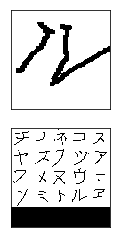

In [14]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [11]:
#Training loop
import matplotlib.pyplot as plt
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 64
n_iter = 50
N_way = 10 # how many classes for testing one-shot tasks>
n_val = 50 #how mahy one-shot tasks to validate on?
best = -1
# weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    weights_path = os.path.join(PATH, "weights-"+str(i))
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc
    print('Iteration:{}, loss:{}'.format(i,loss))

!
training
[4.451325, 0.625]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 36.0% 10 way one-shot learning accuracy
saving
Iteration:1, loss:[4.451325, 0.625]
[4.407914, 0.640625]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 30.0% 10 way one-shot learning accuracy
Iteration:2, loss:[4.407914, 0.640625]
[4.4185834, 0.53125]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 42.0% 10 way one-shot learning accuracy
saving
Iteration:3, loss:[4.4185834, 0.53125]
[4.3867893, 0.546875]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 32.0% 10 way one-shot learning accuracy
Iteration:4, loss:[4.3867893, 0.546875]
[4.3920546, 0.5]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 44.0% 10 way one-shot learning accuracy
saving
Iteration:5, loss:[4.3920546, 0.5]
[4.346876,

[3.5772042, 0.78125]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 26.0% 10 way one-shot learning accuracy
Iteration:43, loss:[3.5772042, 0.78125]
[3.5008364, 0.84375]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 38.0% 10 way one-shot learning accuracy
Iteration:44, loss:[3.5008364, 0.84375]
[3.5479407, 0.75]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 46.0% 10 way one-shot learning accuracy
Iteration:45, loss:[3.5479407, 0.75]
[3.5054722, 0.78125]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 40.0% 10 way one-shot learning accuracy
Iteration:46, loss:[3.5054722, 0.78125]
[3.4538186, 0.859375]
evaluating
Evaluating model on 50 random 10 way one-shot learning tasks ...
Got an average of 42.0% 10 way one-shot learning accuracy
Iteration:47, loss:[3.4538186, 0.859375]
[3.455394, 0.84375]
evaluatin

Evaluating model on 50 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 50 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
Evaluating model on 50 random 3 way one-shot learning tasks ...
Got an average of 70.0% 3 way one-shot learning accuracy
Evaluating model on 50 random 3 way one-shot learning tasks ...
Got an average of 68.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
Evaluating model on 50 random 5 way one-shot learning tasks ...
Got an average of 48.0% 5 way one-shot learning accuracy
Evaluating model on 50 random 5 way one-shot learning tasks ...
Got an average of 56.0% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 5 way one-shot learning tasks ...
Evaluating model on 50 random 7 way one-shot

Got an average of 14.0% 51 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 51 way one-shot learning tasks ...
Evaluating model on 50 random 53 way one-shot learning tasks ...
Got an average of 18.0% 53 way one-shot learning accuracy
Evaluating model on 50 random 53 way one-shot learning tasks ...
Got an average of 22.0% 53 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 53 way one-shot learning tasks ...
Evaluating model on 50 random 55 way one-shot learning tasks ...
Got an average of 14.0% 55 way one-shot learning accuracy
Evaluating model on 50 random 55 way one-shot learning tasks ...
Got an average of 14.0% 55 way one-shot learning accuracy
Evaluating nearest neighbour on 50 unique 55 way one-shot learning tasks ...
Evaluating model on 50 random 57 way one-shot learning tasks ...
Got an average of 6.0% 57 way one-shot learning accuracy
Evaluating model on 50 random 57 way one-shot learning tasks ...
Got an average of 18.0% 57 way o

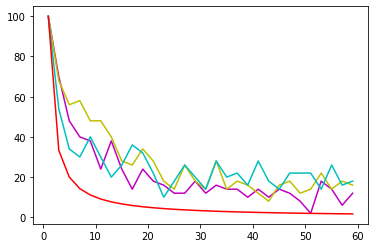

In [12]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 50
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

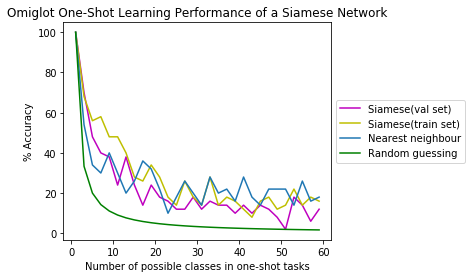

(20, 105, 105, 1)


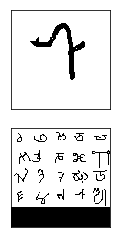

[[0.0802523 ]
 [0.27774218]
 [0.35319692]
 [0.1084515 ]
 [0.03566671]
 [0.31949243]
 [0.08706222]
 [0.07459411]
 [0.03327521]
 [0.5823426 ]
 [0.12620144]
 [0.52370673]
 [0.41055083]
 [0.02810347]
 [0.27758592]
 [0.07379314]
 [0.15997036]
 [0.16414498]
 [0.71249294]
 [0.2154616 ]]


In [17]:

fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [18]:

a=test_nn_accuracy(3,800,loader)
print(a)

Evaluating nearest neighbour on 800 unique 3 way one-shot learning tasks ...
60.125


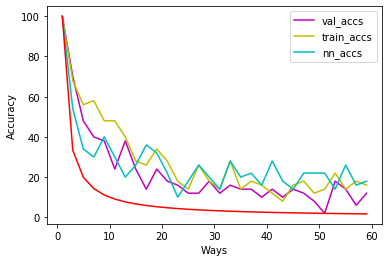

In [23]:
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m",label='val_accs')
plt.plot(ways, train_accs, "y",label='train_accs')
plt.plot(ways, nn_accs, "c",label='nn_accs')

plt.plot(ways,100.0/ways,"r")
plt.xlabel('Ways')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [26]:
print('Weight dimensions for w1 are {}'.format(w1.shape))
print('Weight dimensions for w2 are {}'.format(w2.shape))
print('Weight dimensions for w3 are {}'.format(w3.shape))
print('Weight dimensions for w4 are {}'.format(w4.shape))
print('Weight dimensions for w5 are {}'.format(w5.shape))

Weight dimensions for w1 are (80, 80)
Weight dimensions for w2 are (3136, 128)
Weight dimensions for w3 are (2048, 128)
Weight dimensions for w4 are (2048, 256)
Weight dimensions for w5 are (9216, 4096)


In [49]:
w2=w2[:500,:128]
w3=w3[:500,:128]
w4=w4[:500,:256]
w5=w5[:500,:500]

In [51]:
w1=w1.flatten()
w2=w2.flatten()
w3=w3.flatten()
w4=w4.flatten()
w5=w5.flatten()

In [111]:
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)
print(w5.shape)

(6400,)
(64000,)
(64000,)
(128000,)
(250000,)


4658


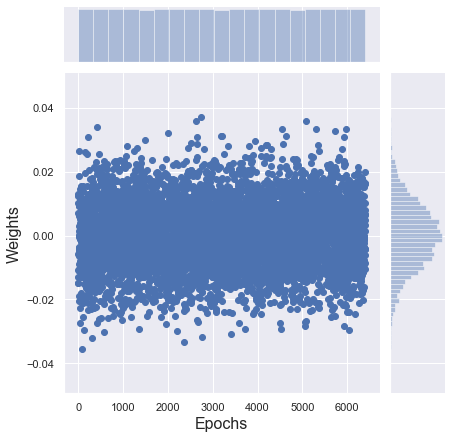

In [132]:
#W1
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
Epochs1=np.arange(0,6400,1)
counter1=0
sns.set()
K1=sns.jointplot(Epochs1,w1)
K1.set_axis_labels('Epochs', 'Weights', fontsize=16)
for i in Epochs1[:-1]:
    if abs(w1[i]-w1[i+1])>0.005:
        counter1=counter1+1
        A1=np.where(abs(w1[i]-w1[i+1]>0.005))
print(counter1)   #COunter is used to count the number of times the weight exceeded the threshold.

34


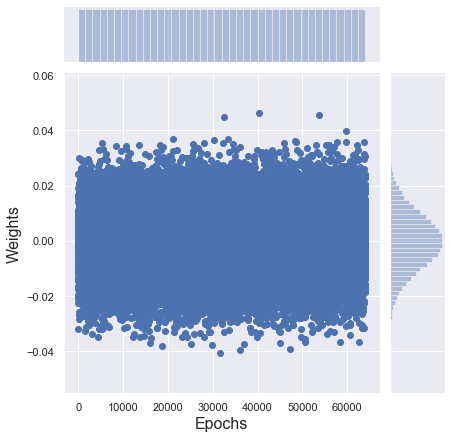

In [137]:
#W2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
Epochs2=np.arange(0,64000,1)
counter2=0
sns.set()
K2=sns.jointplot(Epochs2,w2)
K2.set_axis_labels('Epochs', 'Weights', fontsize=16)
for i in Epochs2[:-1]:
    if abs(w2[i]-w2[i+1])>0.05:
        counter2=counter2+1
        A=np.where(abs(w2[i]-w2[i+1]>0.05))
print(counter2)   #COunter is used to count the number of times the weight exceeded the threshold.

43033


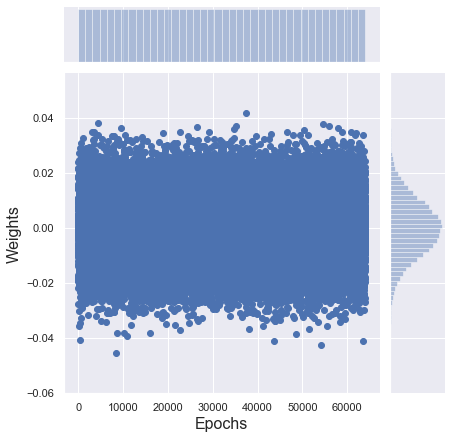

In [138]:
#W3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
Epochs3=np.arange(0,64000,1)
counter3=0
sns.set()
K3=sns.jointplot(Epochs3,w3)
K3.set_axis_labels('Epochs', 'Weights', fontsize=16)
for i in Epochs3[:-1]:
    if abs(w3[i]-w3[i+1])>0.006:
        counter3=counter3+1
        A=np.where(abs(w3[i]-w3[i+1]>0.006))
print(counter3)   #COunter is used to count the number of times the weight exceeded the threshold.

113566


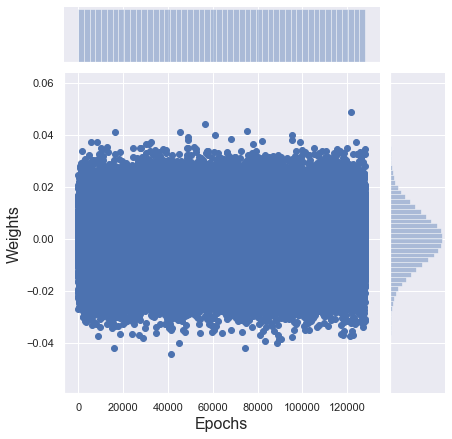

In [139]:
#W4
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
Epochs4=np.arange(0,128000,1)
counter4=0
sns.set()
K4=sns.jointplot(Epochs4,w4)
K4.set_axis_labels('Epochs', 'Weights', fontsize=16)
for i in Epochs4[:-1]:
    if abs(w4[i]-w4[i+1])>0.002:
        counter4=counter4+1
        A=np.where(abs(w4[i]-w4[i+1]>0.002))
print(counter4)   #COunter is used to count the number of times the weight exceeded the threshold.

181098


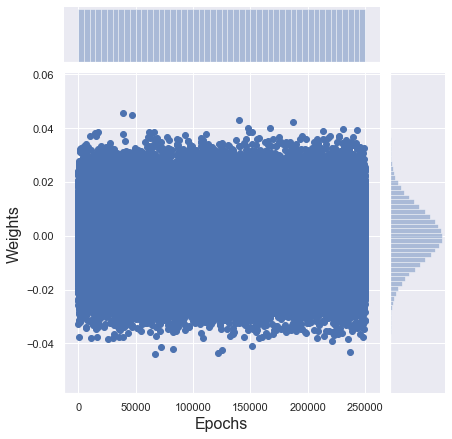

In [141]:
#W5
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
Epochs5=np.arange(0,250000,1)
counter5=0
sns.set()
K5=sns.jointplot(Epochs5,w5)
K5.set_axis_labels('Epochs', 'Weights', fontsize=16)
for i in Epochs5[:-1]:
    if abs(w5[i]-w5[i+1])>0.005:
        counter5=counter5+1
        A=np.where(abs(w5[i]-w5[i+1]>0.007))
print(counter5)   #COunter is used to count the number of times the weight exceeded the threshold.